###  해당 커널은 다음과 같은 프로세스로 진행

1. 데이터 셋 확인
    * 데이터가 어떻게 구성되어 있는지 확인
    * 대부분의 캐글 데이터들은 잘 정제되어 있지만 실제 데이터는 아닐 가능성이 농후
      
    하지만 가끔 null data가 존재합니다. 이를 확인하고, 향후 수정
2. 탐색적 데이터 분석 (EDA, Exploratory Data Analysis)
    * 여러 feature 들을 개별적으로 분석하고, feature 들 간의 상관관계를 확인
      
    여러 시각화 툴을 사용하여 insight를 획득
3. 특성 공학 (Feature Engineering)
    * 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature 들을 engineering 한다.
      
    one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리
4. 모델 개발 및 학습
    * sklearn, keras 을 사용해 모델을 만든다.
    * 파이썬에서 머신러닝을 할 때는 sklearn 을 사용하면 수많은 알고리즘을 일관된 문법으로 사용 가능
    * 또 keras는 딥러닝 개발할 때 모델에 집중할 수 있도록 도움.
    * 물론 딥러닝을 위해 tensorflow, pytorch 등을 사용 가능.
5. 모델 예측 및 평가
    * Train set 을 가지고 모델을 학습시킨 후, Test set 을 가지고 prediction 진행.
   
    그리고 예측 성능이 원하는 수준인지 판단 / 풀려는 문제에 따라 모델을 평가하는 방식도 달라진다.

In [1]:
from scipy.stats import norm
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import pymssql
import os
import joblib
import configparser


## ignore warnings
import warnings
warnings.filterwarnings('ignore')

## matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 
## 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편하다.
plt.style.use('seaborn')
sns.set(font_scale=1.3) 


import missingno as msno
%matplotlib inline

##### 1. 데이터셋 확인

In [2]:
class Data_Preprocess:
    """
    class: Data_preprocess for ML
    1) Based on config file, server, ID, password, DB, case
    """
    
    ### 초기화 및 config 파일 읽어오기.
    def __init__(self, case):
        config = configparser.ConfigParser()
        config.read('AOP_config.cfg')
        
        self.server = config["server address"]["address"]
        self.ID = config["username"]["ID"]
        self.password = config["password"]["PW"]
        self.list_DBs = config["database"]["name"].split(',')
        self.export_DB = config["export database"]["name"]
        self.case = case
        
            
    ### MS-SQL로부터 데이터 가져오기.
    def _sql_get(self):
        print(self.server)
        if self.case == 'model_fit':
            sel_database = self.list_DBs
            
        else:
            sel_database = [self.export_DB]
        print(sel_database)
            
        list_df = []
        for database in sel_database:
            print('---------------')
            print('connect:', database)
            conn = pyodbc.connect(f'DRIVER={{SQL Server}};'
                                  f'SERVER={self.server};'
                                  f'DATABASE={database};'
                                  f'UID={self.ID};'
                                  f'PWD={self.password}')
                
            query = f'''
                        SELECT
                        a.[temperatureId]
                        ,a.[probeId]
                        ,a.[tempSSId]
                        ,a.[measDate]
                        ,a.[measSetNum]
                        ,a.[roomTempC]
                        ,a.[pulseVoltage]
                        ,a.[temperatureC]
                        ,a.[numTxCycles]
                        ,a.[numTxElements]
                        ,a.[txFrequencyHz]
                        ,a.[elevAperIndex]
                        ,a.[isTxAperModulationEn]
                        ,a.[txpgWaveformStyle]
                        ,a.[pulseRepetRate]
                        ,a.[scanRange]
                        ,b.[probeName]
                        ,b.[probePitchCm]
                        ,b.[probeRadiusCm]
                        ,b.[probeElevAperCm0]
                        ,b.[probeElevAperCm1]
                        ,b.[probeNumElements]
                        ,b.[probeElevFocusRangCm] 
                        ,b.[probeDescription]
                        FROM temperature AS a
                        LEFT JOIN probe_geo AS b
                            ON a.[probeId] = b.[probeId]
                        where (a.probeId < 99999999 and a.probeId > 100) and (a.measSetNum = 3 or a.measSetNum = 4)  
                        ORDER BY 1
                        '''
                    
            Raw_data = pd.read_sql_query(sql=query, con = conn)
            Raw_data.insert(0, "Database", f'{database}', True) ## allow_duplicate(중복 삽입 허용) True 설정
            
            print('Data 갯수:', len(Raw_data.index))
            list_df.append(Raw_data)
    
        AOP_data = pd.concat(list_df)
        
        ## 누락된 데이터 삭제 -> probeNumElements를 기준으로 데이터가 누락되어 있으면 전체 열을 삭제.
        AOP_data = AOP_data.dropna(subset=['probeNumElements'])
        
        return AOP_data

In [3]:
if __name__ == '__main__':
    DPP = Data_Preprocess(case='model_fit')
    AOP_data = DPP._sql_get()

kr001s1804srv
['Griffin_r01', 'Frosk_r03', 'New_Trees', 'LEO_4port_r01_AutoReport', 'FROSK_r01_AutoReport', 'FROSK_r02_new']
---------------
connect: Griffin_r01
Data 갯수: 3079
---------------
connect: Frosk_r03
Data 갯수: 875
---------------
connect: New_Trees
Data 갯수: 352
---------------
connect: LEO_4port_r01_AutoReport
Data 갯수: 1221
---------------
connect: FROSK_r01_AutoReport
Data 갯수: 491
---------------
connect: FROSK_r02_new
Data 갯수: 118


---
#### 2. 탐색적 데이터 분석(EDA)
 - 데이터 확인
    - Printing first 5 rows of the train dataset.

In [4]:
AOP_data.head()

,Database,temperatureId,probeId,tempSSId,measDate,measSetNum,roomTempC,pulseVoltage,temperatureC,numTxCycles,...,pulseRepetRate,scanRange,probeName,probePitchCm,probeRadiusCm,probeElevAperCm0,probeElevAperCm1,probeNumElements,probeElevFocusRangCm,probeDescription
0,Griffin_r01,325,11268278,147,2016-08-10,4,22.299999,34.899807,34.000000,2.0,...,2687.000000,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex
1,Griffin_r01,327,11268278,147,2016-08-10,4,22.400000,44.226025,35.099998,2.0,...,1810.520020,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex
2,Griffin_r01,329,11268278,147,2016-08-10,4,22.799999,56.044472,36.299999,2.0,...,1219.949951,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex
3,Griffin_r01,332,11268278,147,2016-08-10,4,23.000000,71.021141,37.599998,2.0,...,822.010010,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex
4,Griffin_r01,334,11268278,147,2016-08-10,4,23.100000,90.000000,38.799999,2.0,...,553.880005,0.0,5C1,0.04765,6.23,1.4,None,128.0,4.88,Convex


In [5]:
## AOP_data 데이터프레임 파라미터 확인.
AOP_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5746 entries, 0 to 117
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Database              5746 non-null   object        
 1   temperatureId         5746 non-null   int64         
 2   probeId               5746 non-null   int64         
 3   tempSSId              5746 non-null   int64         
 4   measDate              5746 non-null   datetime64[ns]
 5   measSetNum            5746 non-null   int64         
 6   roomTempC             5746 non-null   float64       
 7   pulseVoltage          5746 non-null   float64       
 8   temperatureC          5746 non-null   float64       
 9   numTxCycles           5746 non-null   float64       
 10  numTxElements         5746 non-null   int64         
 11  txFrequencyHz         5746 non-null   float64       
 12  elevAperIndex         5746 non-null   int64         
 13  isTxAperModulationEn  57

---
- Null Data 확인

In [7]:
print(AOP_data.isnull().sum())

## 백분율로 변환하여 display
round(AOP_data.isnull().sum()/len(AOP_data) * 100, 2)

Database                   0
temperatureId              0
probeId                    0
tempSSId                   0
measDate                   0
measSetNum                 0
roomTempC                  0
pulseVoltage               0
temperatureC               0
numTxCycles                0
numTxElements              0
txFrequencyHz              0
elevAperIndex              0
isTxAperModulationEn       0
txpgWaveformStyle          0
pulseRepetRate             0
scanRange                  0
probeName                  0
probePitchCm               0
probeRadiusCm            830
probeElevAperCm0           0
probeElevAperCm1        5746
probeNumElements           0
probeElevFocusRangCm       0
probeDescription           0
dtype: int64


Database                  0.00
temperatureId             0.00
probeId                   0.00
tempSSId                  0.00
measDate                  0.00
measSetNum                0.00
roomTempC                 0.00
pulseVoltage              0.00
temperatureC              0.00
numTxCycles               0.00
numTxElements             0.00
txFrequencyHz             0.00
elevAperIndex             0.00
isTxAperModulationEn      0.00
txpgWaveformStyle         0.00
pulseRepetRate            0.00
scanRange                 0.00
probeName                 0.00
probePitchCm              0.00
probeRadiusCm            14.44
probeElevAperCm0          0.00
probeElevAperCm1        100.00
probeNumElements          0.00
probeElevFocusRangCm      0.00
probeDescription          0.00
dtype: float64

---
- Null data 시각화
    - probeRadiusCm / probeEleAperCm1** 누락 데이터 발견 및 앞으로 해당 parameter 어떻게 할 지 계획  

<Axes: >

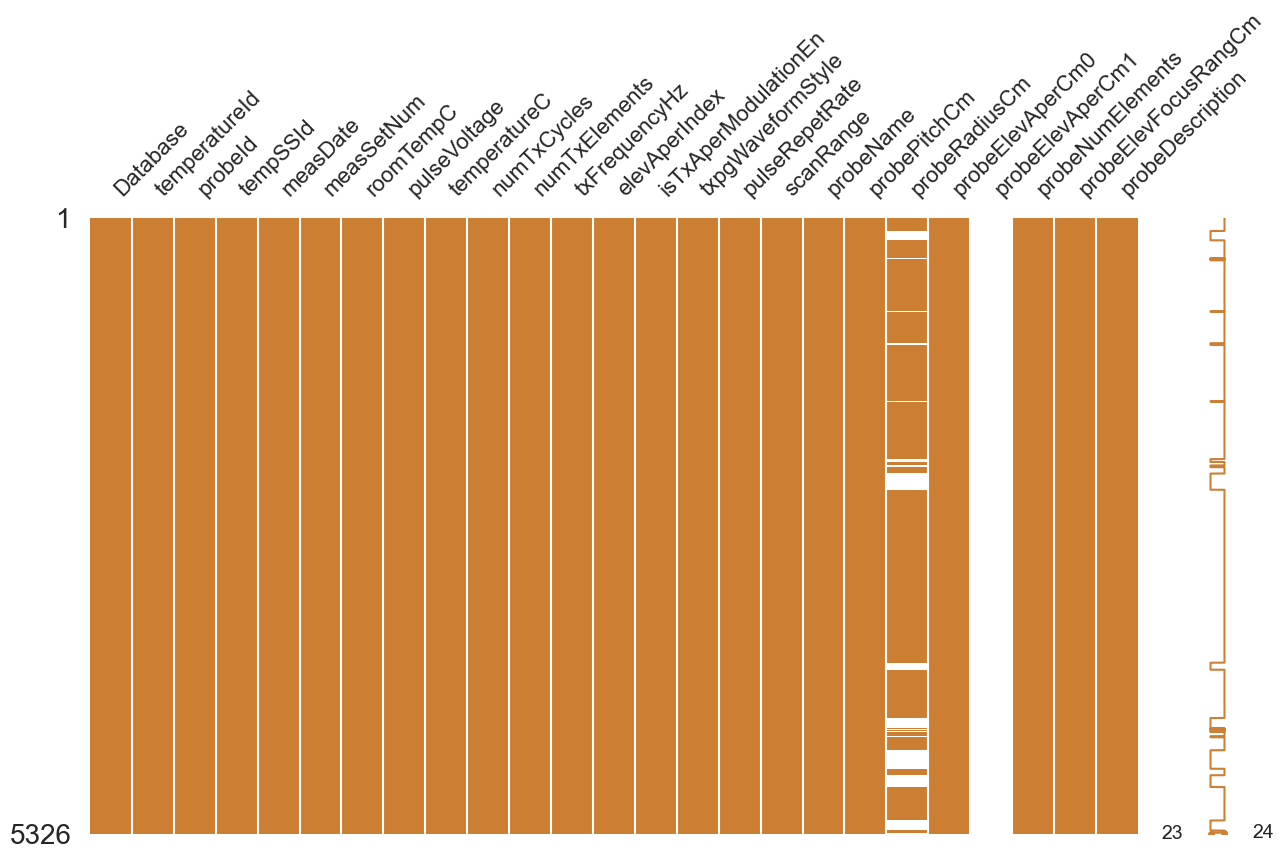

In [8]:
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(15,8), color=(0.8, 0.5, 0.2))

-  1) probeRadiusCm [NULL] 데이터 --> [0]으로 변경
-  2) probeElevAperCm1 컬럼 데이터 전부 삭제
-  3) probeDescription 명확하게 구분화
      - Curved, Convex, Linear, Phased

---
#### Target 데이터의 분석
- temperatureC - roomTempC 분석
- histogram이용하여 분석
- Skewness / 왜도
    - symmetrical bell curve 혹은 normal distribution에서 왜곡 정도를 말한다. 데이터 분포의 대칭성이 얼마나 결핍되었는지를 측정한다. 완전히 대칭인 분포는 skewness가 0이다.
    - 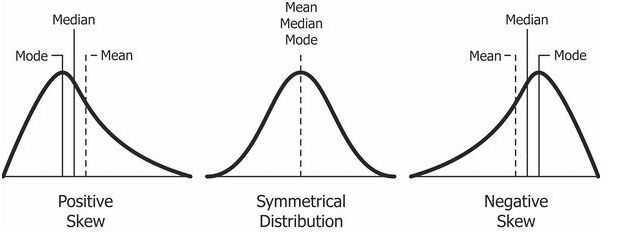

---
#### TemperatureRise 분석


 mu = 13.94 and sigma = 6.97



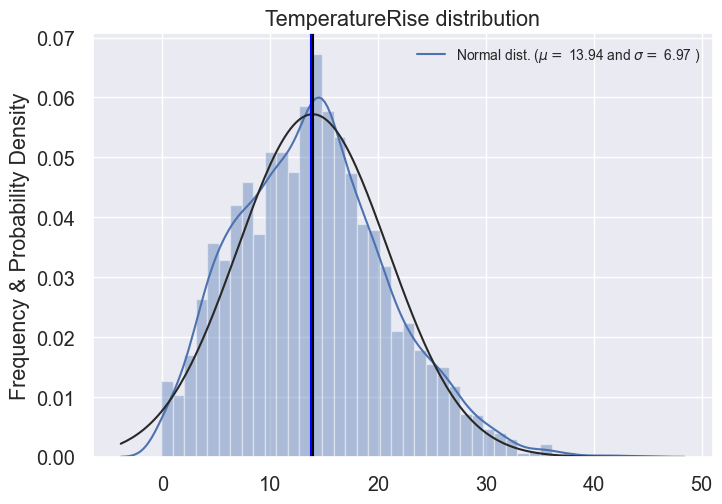

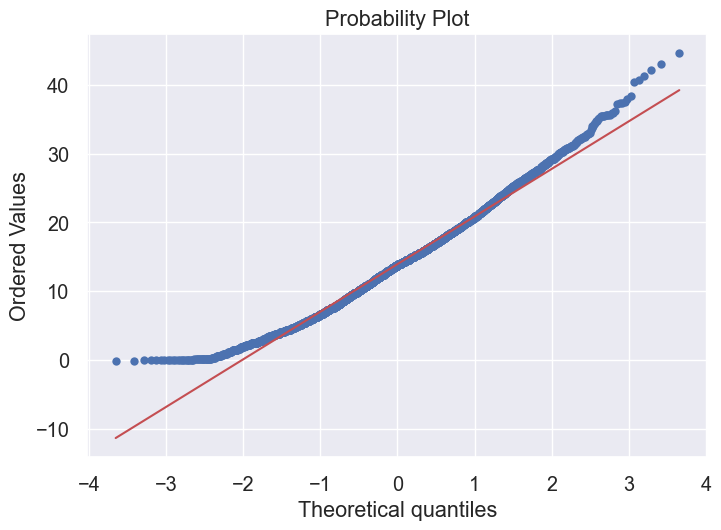

Skewness & TempRise: 0.419936
Kurtosis & TempRise: 0.080905


In [14]:
TemperatureRise = (AOP_data['temperatureC'] - AOP_data['roomTempC'])

sns.distplot(TemperatureRise , fit=norm)

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(TemperatureRise)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('Frequency & Probability Density')
plt.title('TemperatureRise distribution')

## TemperatureRise mean and median value display
plt.axvline(TemperatureRise.mean(), color='black')
plt.axvline(TemperatureRise.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(TemperatureRise, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & TempRise: %f" % TemperatureRise.skew())
print("Kurtosis & TempRise: %f" % TemperatureRise.kurt())

---
#### Temperature 분석


 mu = 36.72 and sigma = 7.00



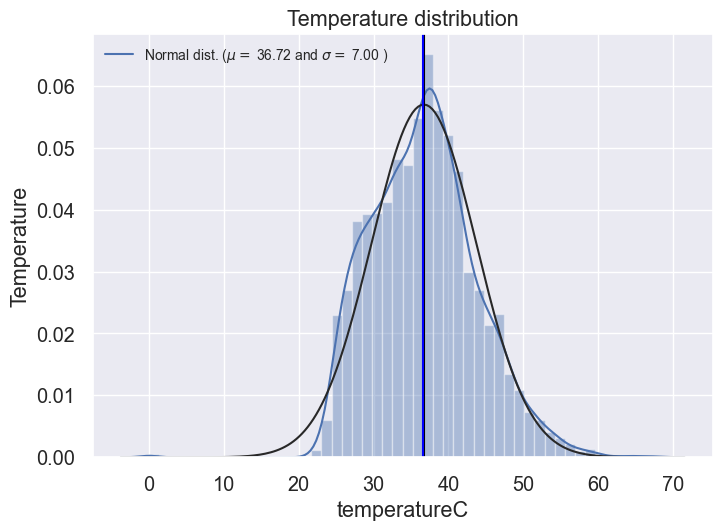

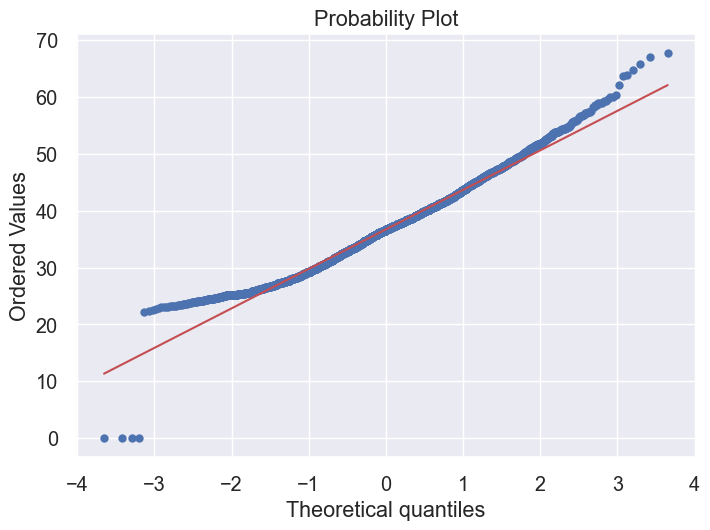

Skewness & Temp: 0.313393
Kurtosis & Temp: 0.522297


In [11]:
Temperature = (AOP_data['temperatureC'])

sns.distplot(Temperature , fit=norm);

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Temperature)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('Temperature')
plt.title('Temperature distribution')

## Temperature mean and median value display
plt.axvline(Temperature.mean(), color='black')
plt.axvline(Temperature.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Temperature, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & Temp: %f" % Temperature.skew())
print("Kurtosis & Temp: %f" % Temperature.kurt())

---
#### log transform 변환하여 확인하기


 mu = 2.56 and sigma = 0.59



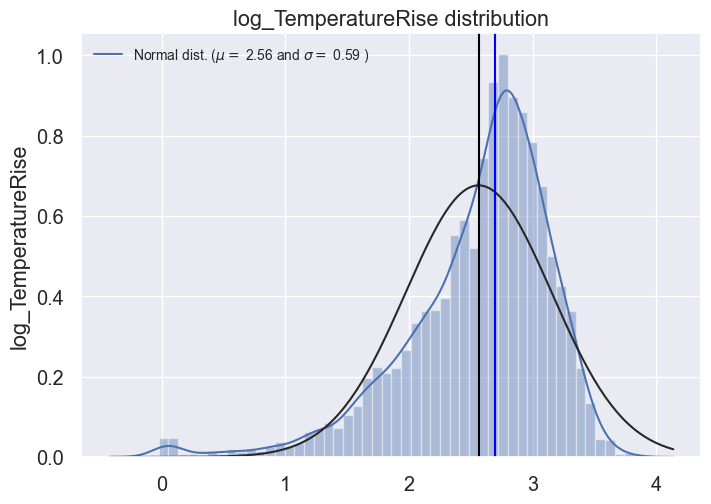

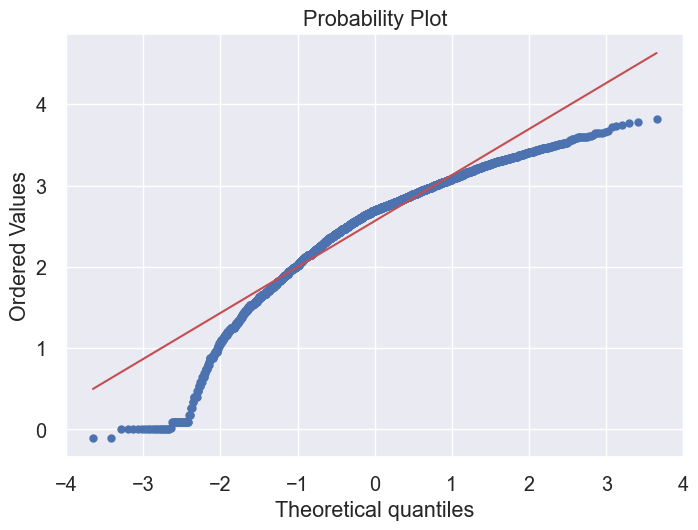

Skewness & TempRise: -1.311257
Kurtosis & TempRise: 2.656557


In [12]:
log_temp_rise = np.log1p(TemperatureRise)

sns.distplot(log_temp_rise , fit=norm);

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_temp_rise)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('log_TemperatureRise')
plt.title('log_TemperatureRise distribution')

## TemperatureRise mean and median value display
plt.axvline(log_temp_rise.mean(), color='black')
plt.axvline(log_temp_rise.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_temp_rise, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & TempRise: %f" % log_temp_rise.skew())
print("Kurtosis & TempRise: %f" % log_temp_rise.kurt())

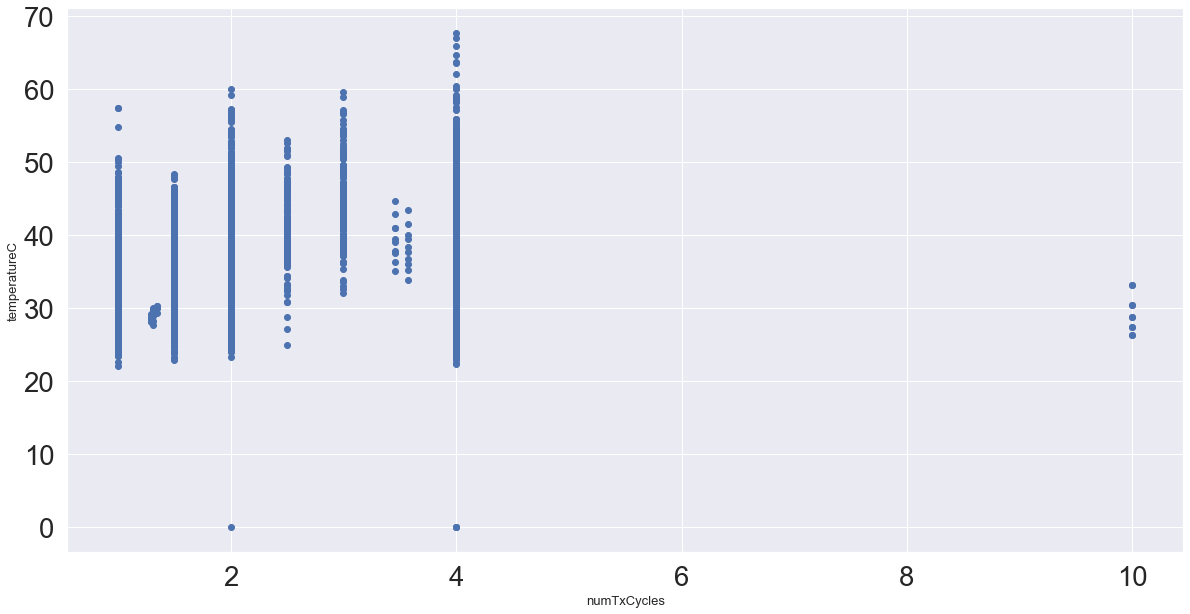

In [185]:
fig, axs = plt.subplots(figsize=(20,10))
axs.scatter(x = AOP_data['numTxCycles'], y = AOP_data['temperatureC'])
plt.xlabel('numTxCycles', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

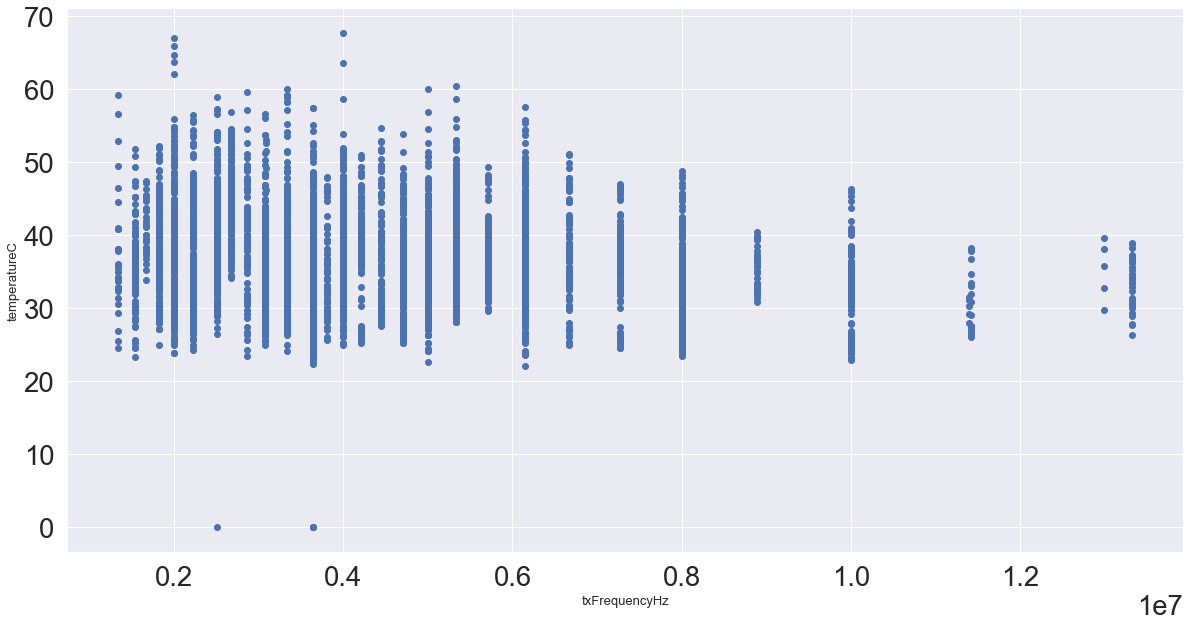

In [186]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['txFrequencyHz'], y = AOP_data['temperatureC'])
plt.xlabel('txFrequencyHz', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

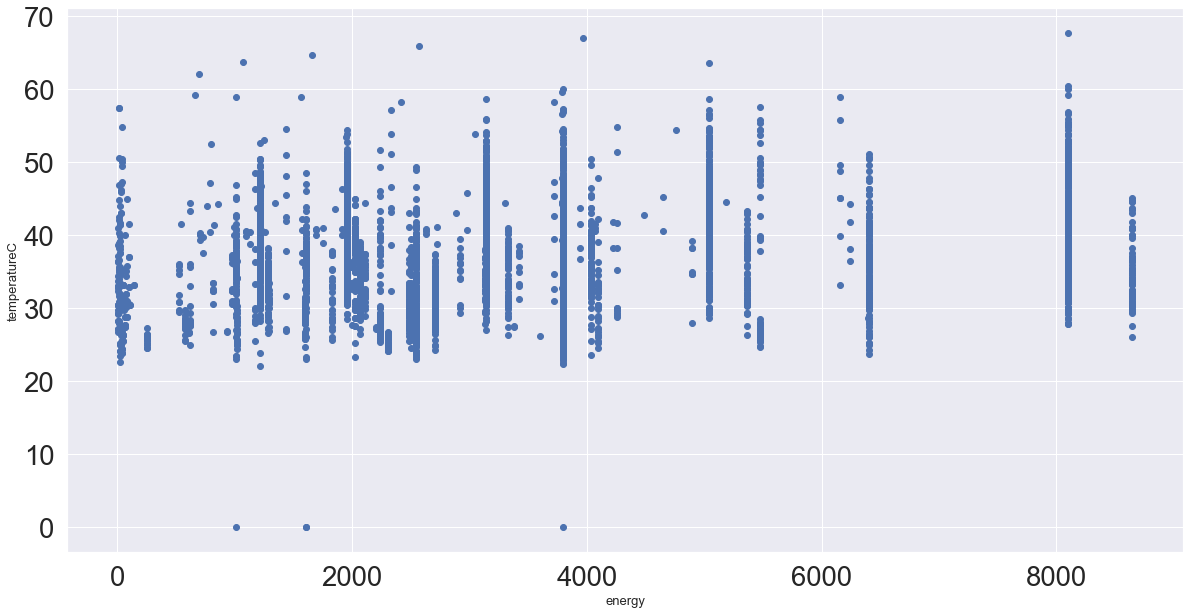

In [187]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['pulseVoltage'] * AOP_data['pulseVoltage'], y = AOP_data['temperatureC'])
plt.xlabel('energy', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

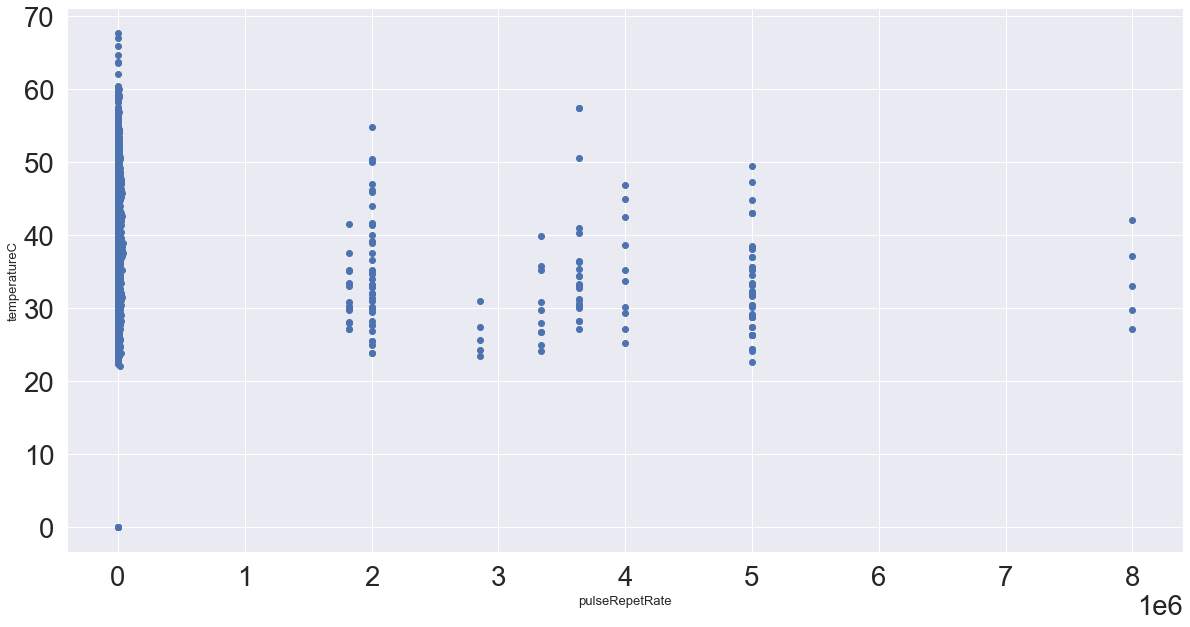

In [188]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['pulseRepetRate'], y = AOP_data['temperatureC'])
plt.xlabel('pulseRepetRate', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

In [189]:
print(AOP_data[(AOP_data['temperatureC']==0)].index)
print(AOP_data[(AOP_data['temperatureC']<26)].index)

print(len(AOP_data[(AOP_data['temperatureC']<26)].index))

# AOP_data = AOP_data.drop(AOP_data[AOP_data['temperatureC']].index)

Int64Index([793, 794, 796], dtype='int64')
Int64Index([ 586, 1055, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076,
            ...
             474,  476,  477,  478,  481,   56,   61,   62,  106,  107],
           dtype='int64', length=184)
184


In [190]:
## numpy로 변환하여 데이터 확인하기.
df_AOP = AOP_data[AOP_data['pulseRepetRate']>18000]
PRF_AOP = df_AOP['pulseRepetRate']
data = PRF_AOP.to_numpy()
print(np.unique(data, return_counts=True))

(array([  18053.        ,   18059.5       ,   18166.        ,
         18344.80078125,   18662.69921875,   18894.5       ,
         19091.5       ,   19437.19921875,   19500.        ,
         19503.30078125,   19531.19921875,   19600.69921875,
         19763.30078125,   20040.5       ,   20093.30078125,
         20249.80078125,   20298.69921875,   20436.        ,
         20598.        ,   20619.80078125,   20879.69921875,
         20996.69921875,   21192.69921875,   21297.19921875,
         21338.19921875,   21445.5       ,   22155.69921875,
         22428.19921875,   22513.69921875,   22642.69921875,
         23014.80078125,   23059.30078125,   23200.80078125,
         23417.19921875,   23706.5       ,   24962.19921875,
         26069.        ,   26263.69921875,   26354.5       ,
         26356.30078125,   26647.80078125,   26841.69921875,
         27227.5       ,   27352.30078125,   28606.30078125,
         29919.19921875,   30439.        ,   33262.69921875,
         33754.        

In [191]:
## Dataframe
print(df_AOP['pulseRepetRate'].unique())
print(df_AOP['pulseRepetRate'].value_counts())
print('pulseRepetRate 종류 갯수:', df_AOP['pulseRepetRate'].nunique())


# data = AOP_data[AOP_data['pulseRepetRate']>18000].to_numpy()
print(len(AOP_data[(AOP_data['pulseRepetRate']>18000)].index))
# print(AOP_data[(AOP_data['pulseRepetRate']>18000)])

[5000000.         2000000.           18059.5          20249.80078125
   18662.69921875   18894.5        3636400.           19091.5
 3333300.         8000000.         4000000.         1818200.
   30439.           18166.           26841.69921875 2857100.
   29919.19921875   26263.69921875   33262.69921875   19763.30078125
   23706.5          20619.80078125   35243.5          20879.69921875
   38000.           22428.19921875   26647.80078125   27352.30078125
   19437.19921875   22513.69921875   18053.           20298.69921875
   20598.           23059.30078125   23417.19921875   21338.19921875
   19500.           21297.19921875   22642.69921875   28606.30078125
   18344.80078125   34455.5          20436.           27227.5
   20996.69921875   26354.5          33754.           20040.5
   19503.30078125   26069.           23200.80078125   19600.69921875
   20093.30078125   22155.69921875   21445.5          21192.69921875
   23014.80078125   26356.30078125   24962.19921875   19531.19921875]
2

##### Drop unnecessary data
- pulseRepetRate가 18000(CW-mode) 이상이거나 또는 온도가 26도 미만일 경우는 Drop.
- As below, Drop condition output test code.
    - AOP_data[(AOP_data['temperatureC']<26) | (AOP_data['pulseRepetRate']>18000)].to_csv('drop_data.csv')

In [192]:
print('Before drop unnecessary data:', AOP_data.shape)

## <Drop unnecessary data>
## pulseRepetRate가 18000(CW) 이상이거나 또는 온도가 26도 미만일 경우는 Drop.
AOP_data = AOP_data.drop(AOP_data[(AOP_data['temperatureC']<26) | (AOP_data['pulseRepetRate']>18000)].index)
print('After drop unnecessary data:', AOP_data.shape)

Before drop unnecessary data: (4822, 25)
After drop unnecessary data: (3924, 25)


##### probeRadiusCm 데이터에서 Null데이터 채우기
- Null 데이터는 Linear probe이기에 ProbeRadiusCm 데이터에 '0'을 채운다.

<AxesSubplot:>

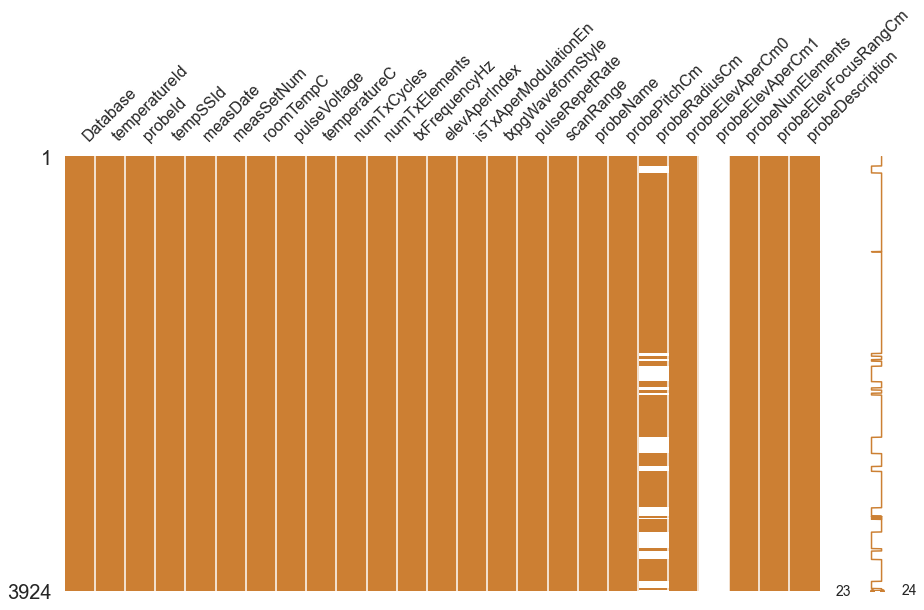

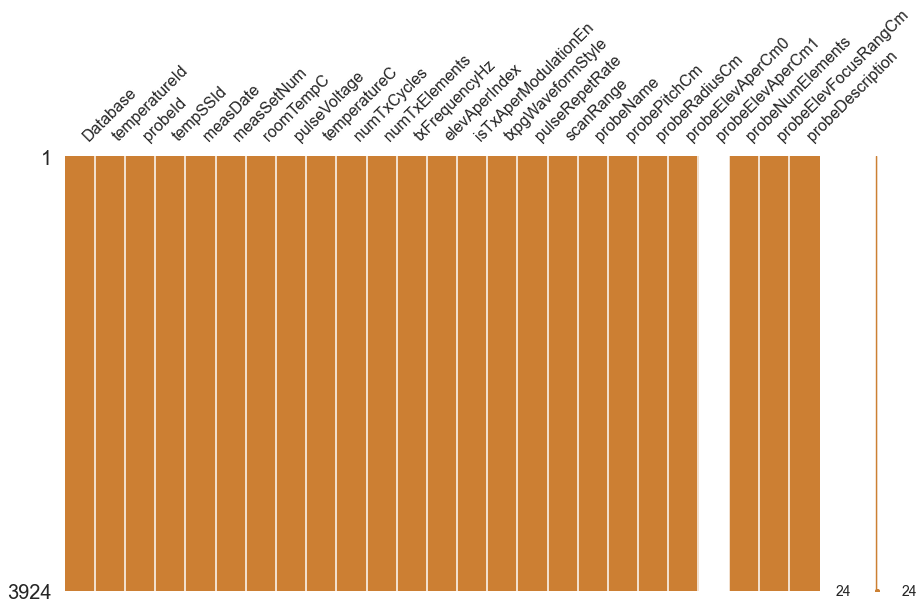

In [193]:
msno.matrix(df=AOP_data, figsize=(15,8), color=(0.8, 0.5, 0.2))
AOP_data['probeRadiusCm'] = AOP_data['probeRadiusCm'].fillna(0)

msno.matrix(df=AOP_data, figsize=(15,8), color=(0.8, 0.5, 0.2))

##### Data Correlation
- Correlation map to see how features are correlated with TemperatureRise

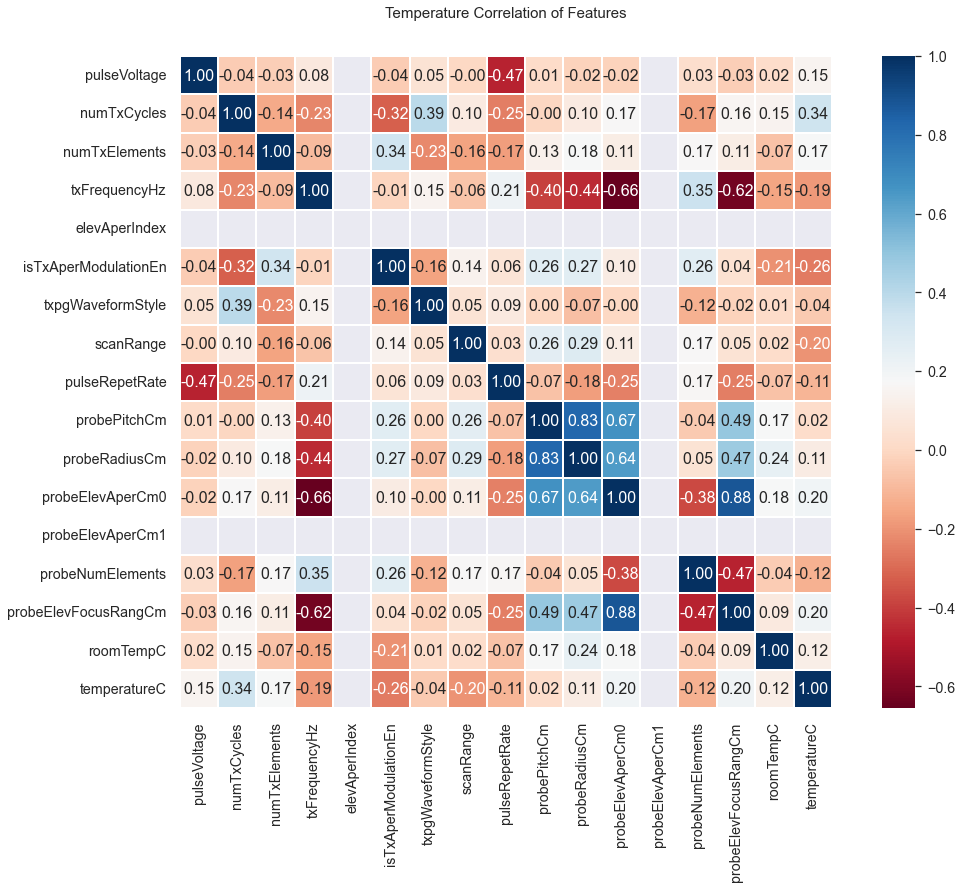

In [228]:
heatmap_data = AOP_data[['pulseVoltage', 'numTxCycles', 'numTxElements', 'txFrequencyHz', 'elevAperIndex',
                         'isTxAperModulationEn', 'txpgWaveformStyle', 'scanRange', 'pulseRepetRate', 'probePitchCm',
                         'probeRadiusCm', 'probeElevAperCm0', 'probeElevAperCm1', 'probeNumElements', 'probeElevFocusRangCm', 'roomTempC', 'temperatureC']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(18, 12))
plt.title('Temperature Correlation of Features', y=1.05, size=15)

sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, fmt='.2f',
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

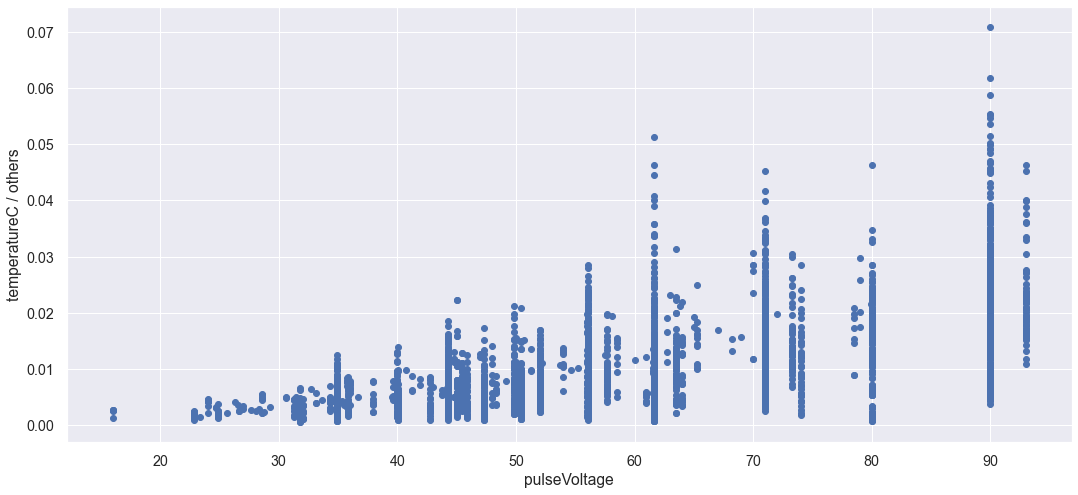

In [262]:
plt.figure(figsize=(18, 8))
plt.scatter(x = AOP_data['pulseVoltage'], y = AOP_data['temperatureC'] / (AOP_data['numTxCycles'] * AOP_data['pulseRepetRate'] ))
plt.xlabel('pulseVoltage')
plt.ylabel('temperatureC / others')
plt.show()

In [6]:
if __name__ == '__main__':
    DPP = Data_Preprocess(case='model_fit')
    AOP_data = DPP._sql_get()
    ##### in progress #####
    ## AOP_data라는 데이터가 있을 경우, SQL에서 데이터를 읽어오지 않기  

kr001s1804srv
['Griffin_r01', 'Frosk_r03', 'New_Trees', 'LEO_4port_r01_AutoReport', 'FROSK_r01_AutoReport', 'FROSK_r02_new']
---------------
connect: Griffin_r01
Data 갯수: 2754
---------------
connect: Frosk_r03
Data 갯수: 875
---------------
connect: New_Trees
Data 갯수: 257
---------------
connect: LEO_4port_r01_AutoReport
Data 갯수: 1221
---------------
connect: FROSK_r01_AutoReport
Data 갯수: 491
---------------
connect: FROSK_r02_new
Data 갯수: 118
